**Step 1: Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


**Step 2: Load and Explore the Data**

In [2]:
# Load the dataset
df = pd.read_csv(r'C:\Users\Admin\Documents\EXCELR\DS Assignments\@\monthly_milk_production.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print(f"\nMissing Values: {df.isnull().sum().sum()}")


Dataset Shape: (168, 1)

First 5 rows:
            Production
Date                  
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727

Last 5 rows:
            Production
Date                  
1975-08-01         858
1975-09-01         817
1975-10-01         827
1975-11-01         797
1975-12-01         843

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB
None

Basic Statistics:
       Production
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000

Missing Values: 0


**Step 3: Exploratory Data Analysis (EDA)**

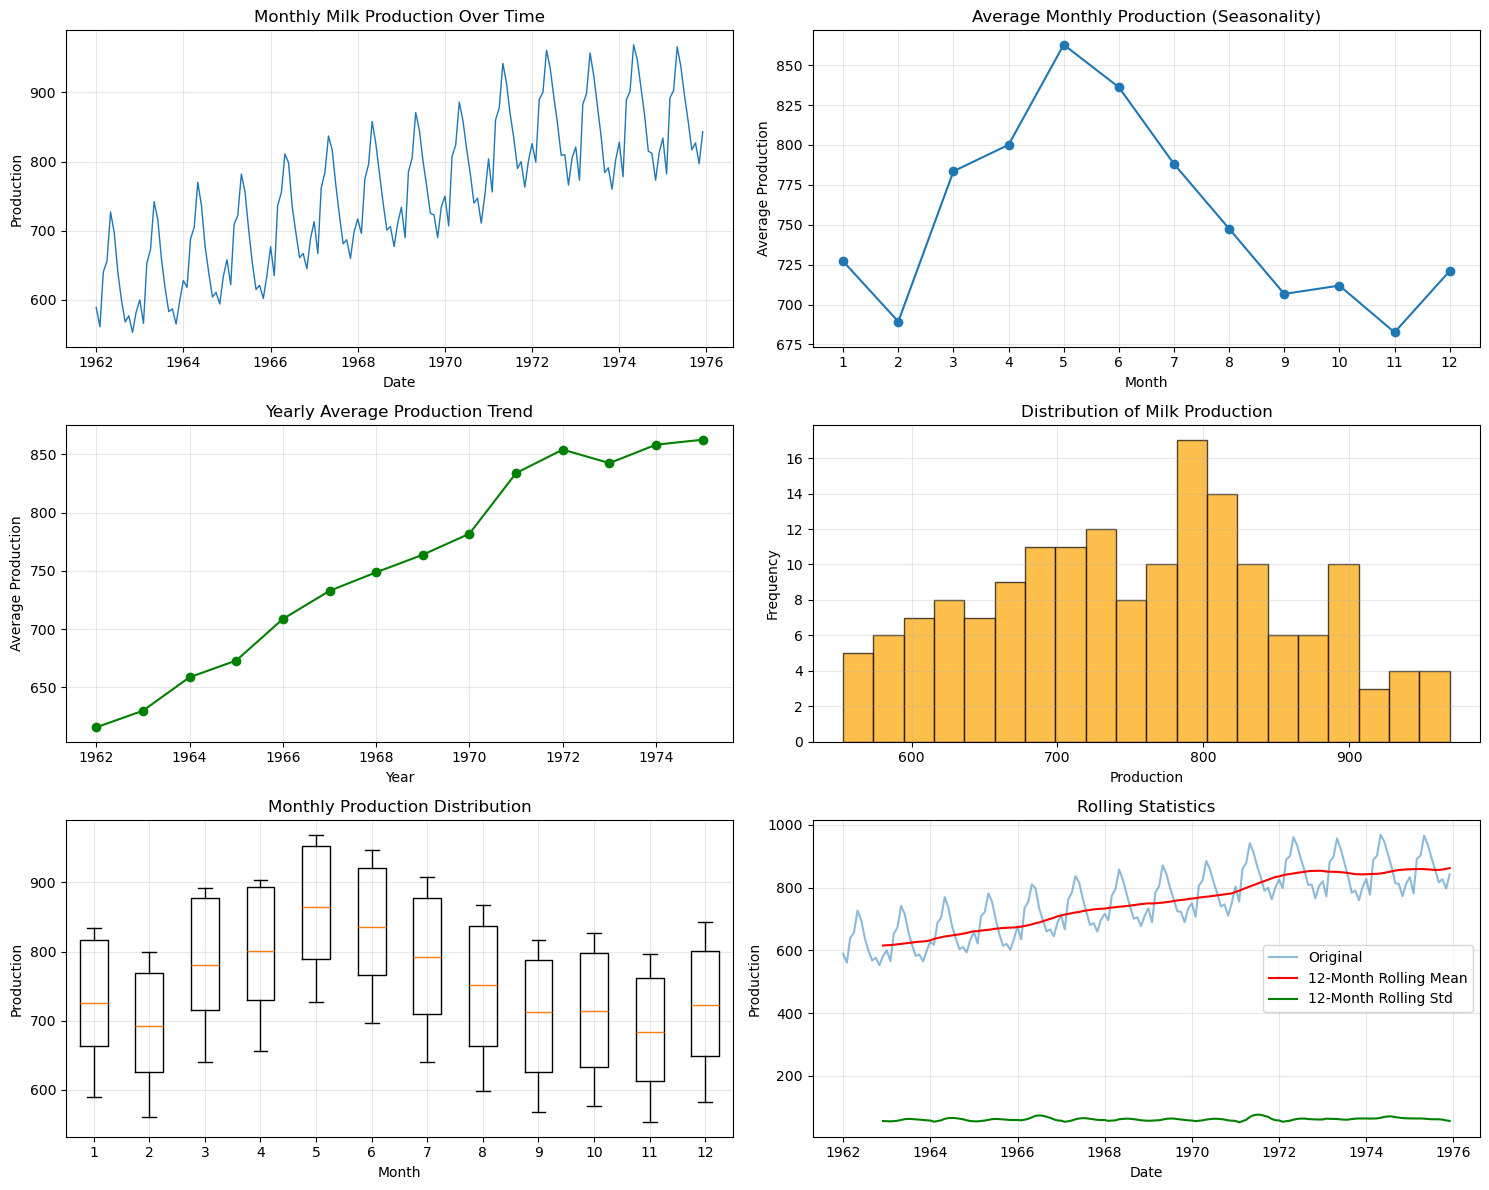

Exploratory Data Analysis completed


In [3]:
plt.figure(figsize=(15, 12))

# Plot 1: Time series plot
plt.subplot(3, 2, 1)
plt.plot(df.index, df['Production'], linewidth=1)
plt.title('Monthly Milk Production Over Time')
plt.xlabel('Date')
plt.ylabel('Production')
plt.grid(True, alpha=0.3)

# Plot 2: Seasonal decomposition (simple version)
df['Year'] = df.index.year
df['Month'] = df.index.month

plt.subplot(3, 2, 2)
seasonal_data = df.groupby('Month')['Production'].mean()
plt.plot(seasonal_data.index, seasonal_data.values, marker='o')
plt.title('Average Monthly Production (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Average Production')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)

# Plot 3: Yearly trends
plt.subplot(3, 2, 3)
yearly_data = df.groupby('Year')['Production'].mean()
plt.plot(yearly_data.index, yearly_data.values, marker='o', color='green')
plt.title('Yearly Average Production Trend')
plt.xlabel('Year')
plt.ylabel('Average Production')
plt.grid(True, alpha=0.3)

# Plot 4: Distribution of production
plt.subplot(3, 2, 4)
plt.hist(df['Production'], bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution of Milk Production')
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 5: Boxplot by month
plt.subplot(3, 2, 5)
monthly_boxplot_data = [df[df['Month'] == month]['Production'].values for month in range(1, 13)]
plt.boxplot(monthly_boxplot_data, labels=range(1, 13))
plt.title('Monthly Production Distribution')
plt.xlabel('Month')
plt.ylabel('Production')
plt.grid(True, alpha=0.3)

# Plot 6: Rolling statistics
plt.subplot(3, 2, 6)
rolling_mean = df['Production'].rolling(window=12).mean()
rolling_std = df['Production'].rolling(window=12).std()
plt.plot(df.index, df['Production'], label='Original', alpha=0.5)
plt.plot(df.index, rolling_mean, label='12-Month Rolling Mean', color='red')
plt.plot(df.index, rolling_std, label='12-Month Rolling Std', color='green')
plt.title('Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Remove temporary columns
df = df[['Production']]

print("Exploratory Data Analysis completed")

**Step 4: Data Preprocessing and Preparation**

In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Function to create sequences for time series forecasting
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Set parameters
SEQUENCE_LENGTH = 12  # Using 12 months to predict next month
TEST_SIZE = 0.2  # 20% for testing

# Create sequences
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

# Split into train and test sets
split_index = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape data for deep learning models (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set shape: X_test {X_test.shape}, y_test {y_test.shape}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

print("Data preprocessing and preparation completed")

Training set shape: X_train (124, 12, 1), y_train (124,)
Test set shape: X_test (32, 12, 1), y_test (32,)
Sequence length: 12
Training samples: 124
Testing samples: 32
Data preprocessing and preparation completed


**Step 5: Build and Train Deep Learning Models**

In [5]:
def build_rnn_model(sequence_length, units=50):
    model = Sequential([
        SimpleRNN(units, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        SimpleRNN(units, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

def build_lstm_model(sequence_length, units=50):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(units, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

def build_gru_model(sequence_length, units=50):
    model = Sequential([
        GRU(units, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        GRU(units, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

# Build models
rnn_model = build_rnn_model(SEQUENCE_LENGTH)
lstm_model = build_lstm_model(SEQUENCE_LENGTH)
gru_model = build_gru_model(SEQUENCE_LENGTH)

# Compile models
models = {
    'RNN': rnn_model,
    'LSTM': lstm_model,
    'GRU': gru_model
}

for name, model in models.items():
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    print(f"{name} Model Summary:")
    model.summary()
    print()

print("Models built successfully")

RNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 12, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)


LSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


GRU Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 12, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)


Models built successfully


**Step 6: Train the Models**

In [6]:
# Training parameters
EPOCHS = 100
BATCH_SIZE = 32

# Store training history
history_dict = {}

print("Training models...")
for name, model in models.items():
    print(f"\nTraining {name} model...")
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test),
        verbose=0,
        shuffle=False
    )
    history_dict[name] = history
    print(f"{name} model training completed")

print("All models trained successfully")

Training models...

Training RNN model...
RNN model training completed

Training LSTM model...
LSTM model training completed

Training GRU model...
GRU model training completed
All models trained successfully


**Step 7: Model Evaluation and Comparison**

In [7]:
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# Make predictions
predictions = {}
metrics_results = {}

for name, model in models.items():
    # Make predictions
    y_pred_scaled = model.predict(X_test, verbose=0)

    # Reshape for inverse transformation
    y_pred_scaled_2d = y_pred_scaled.reshape(-1, 1)
    y_test_2d = y_test.reshape(-1, 1)

    # Inverse transform predictions and actual values
    y_pred = scaler.inverse_transform(y_pred_scaled_2d)
    y_actual = scaler.inverse_transform(y_test_2d)

    predictions[name] = (y_actual.flatten(), y_pred.flatten())

    # Calculate metrics
    rmse, mae, mape = calculate_metrics(y_actual, y_pred)
    metrics_results[name] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Display metrics comparison
metrics_df = pd.DataFrame(metrics_results).T
print("\nModel Performance Comparison:")
print(metrics_df.round(2))

# Find best model
best_model_name = metrics_df['RMSE'].idxmin()
print(f"\n🏆 Best Model: {best_model_name} (Lowest RMSE)")

print("Model evaluation completed")


Model Performance Comparison:
       RMSE    MAE  MAPE
RNN   16.77  13.28  1.56
LSTM  23.94  19.21  2.31
GRU   33.33  25.23  2.95

🏆 Best Model: RNN (Lowest RMSE)
Model evaluation completed


**Step 8: Visualize Results and Training History**

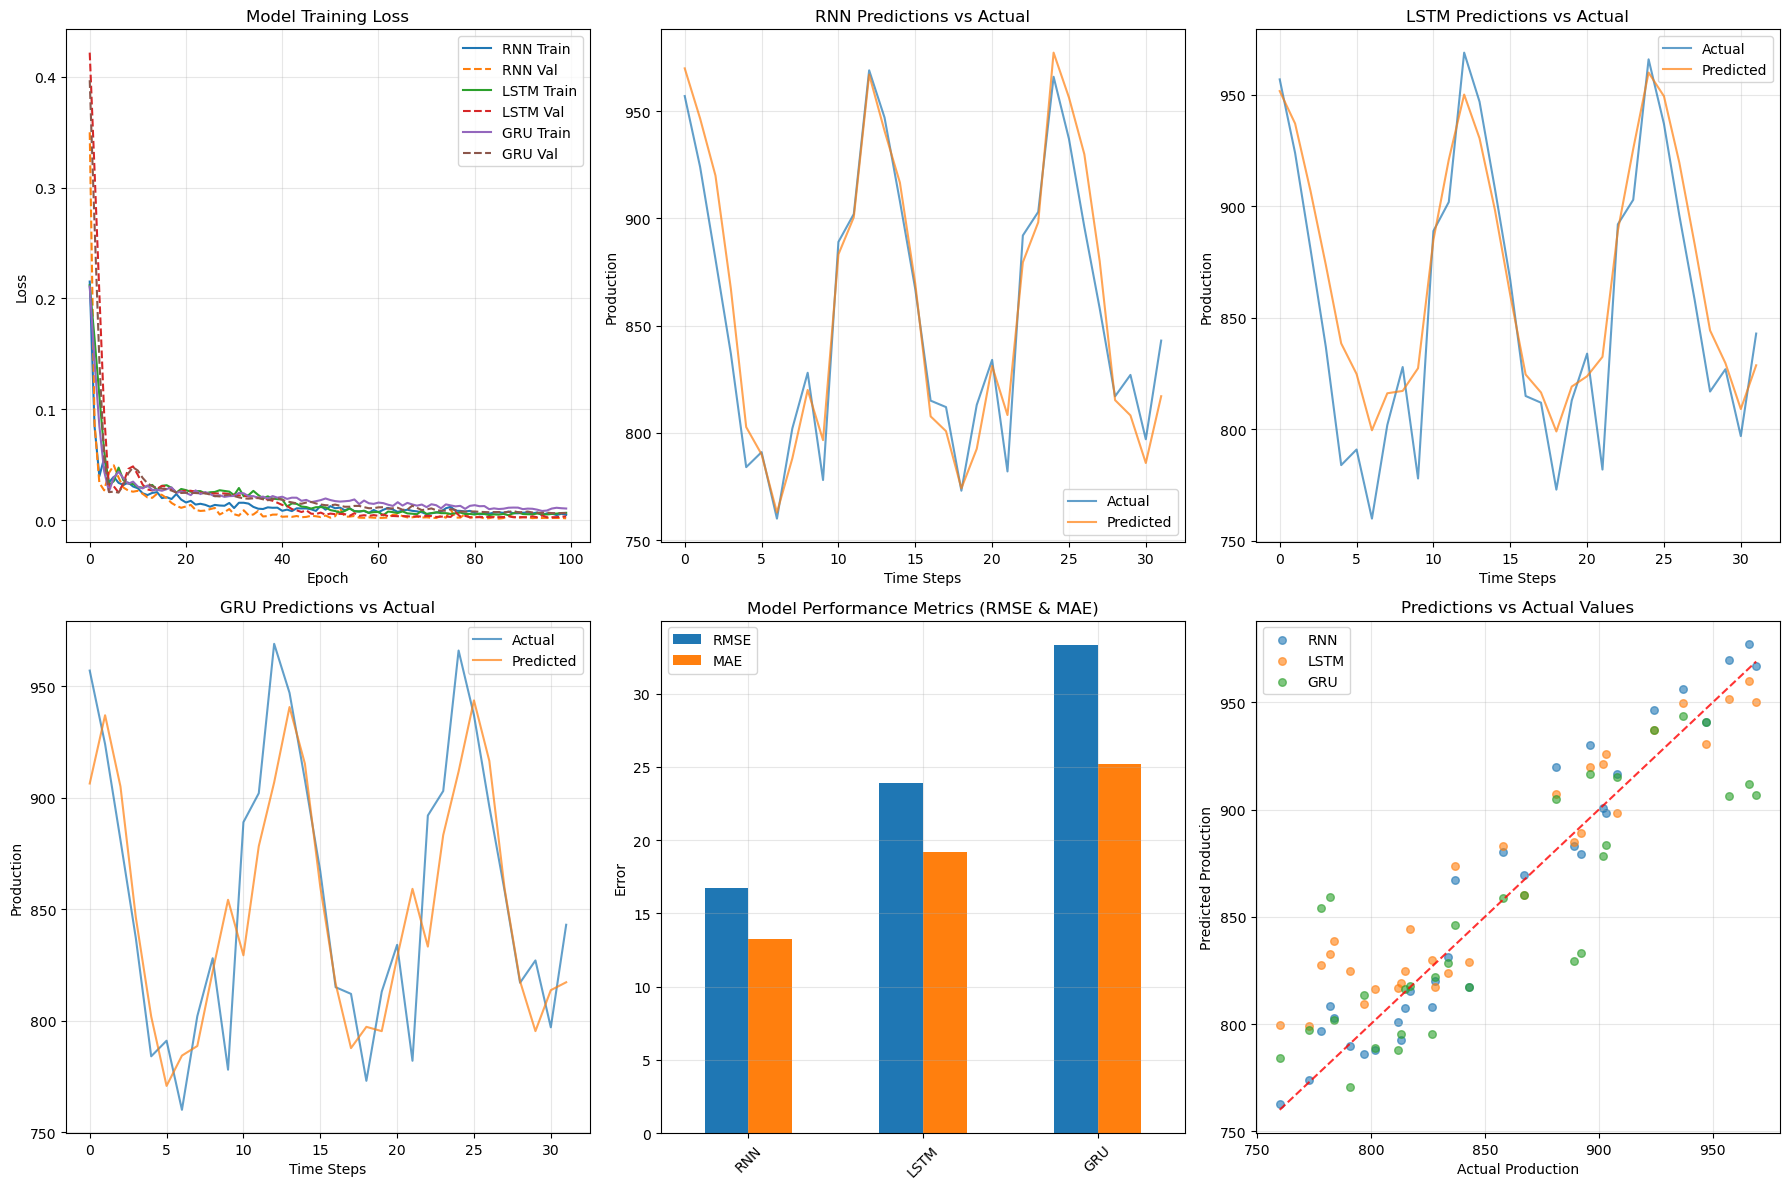

Results visualization completed


In [8]:
plt.figure(figsize=(18, 12))

# Plot 1: Training history (loss)
plt.subplot(2, 3, 1)
for name, history in history_dict.items():
    plt.plot(history.history['loss'], label=f'{name} Train')
    plt.plot(history.history['val_loss'], label=f'{name} Val', linestyle='--')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual values
for i, (name, (y_actual, y_pred)) in enumerate(predictions.items(), 2):
    plt.subplot(2, 3, i)
    plt.plot(y_actual, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f'{name} Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Production')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot 3: Metrics comparison
plt.subplot(2, 3, 5)
metrics_df[['RMSE', 'MAE']].plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Metrics (RMSE & MAE)')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 4: Scatter plots of predictions vs actual
plt.subplot(2, 3, 6)
for name, (y_actual, y_pred) in predictions.items():
    plt.scatter(y_actual, y_pred, alpha=0.6, label=name, s=30)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', alpha=0.8)
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Results visualization completed")

**Step 9: Future Production Forecasting**

In [9]:
def forecast_future(model, last_sequence, n_steps):
    """Forecast n_steps into the future"""
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        # Get the prediction
        next_pred = model.predict(current_sequence.reshape(1, SEQUENCE_LENGTH, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])

        # Update the sequence
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]

    return np.array(future_predictions)

# Get the last sequence from the data
last_sequence_scaled = scaled_data[-SEQUENCE_LENGTH:].flatten()

# Forecast next 12 months
forecast_months = 12
future_forecasts = {}

for name, model in models.items():
    future_scaled = forecast_future(model, last_sequence_scaled, forecast_months)
    future_predictions = scaler.inverse_transform(future_scaled.reshape(-1, 1)).flatten()
    future_forecasts[name] = future_predictions

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                            periods=forecast_months, freq='M')

print("🔮 Future Production Forecasts (Next 12 Months):")
forecast_df = pd.DataFrame(future_forecasts, index=future_dates)
print(forecast_df.round(1))

print("Future forecasting completed")

🔮 Future Production Forecasts (Next 12 Months):
                   RNN        LSTM         GRU
1976-01-31  856.700012  831.700012  852.099976
1976-02-29  839.299988  838.500000  872.799988
1976-03-31  913.500000  897.000000  891.200012
1976-04-30  921.099976  930.200012  899.900024
1976-05-31  982.000000  960.500000  901.099976
1976-06-30  954.599976  941.400024  892.000000
1976-07-31  936.299988  909.400024  874.599976
1976-08-31  892.799988  877.099976  854.200012
1976-09-30  840.400024  849.500000  837.500000
1976-10-31  826.299988  841.900024  830.299988
1976-11-30  798.900024  830.000000  831.400024
1976-12-31  828.900024  847.099976  842.400024
Future forecasting completed


**Step 10: Final Visualization and Business Insights**

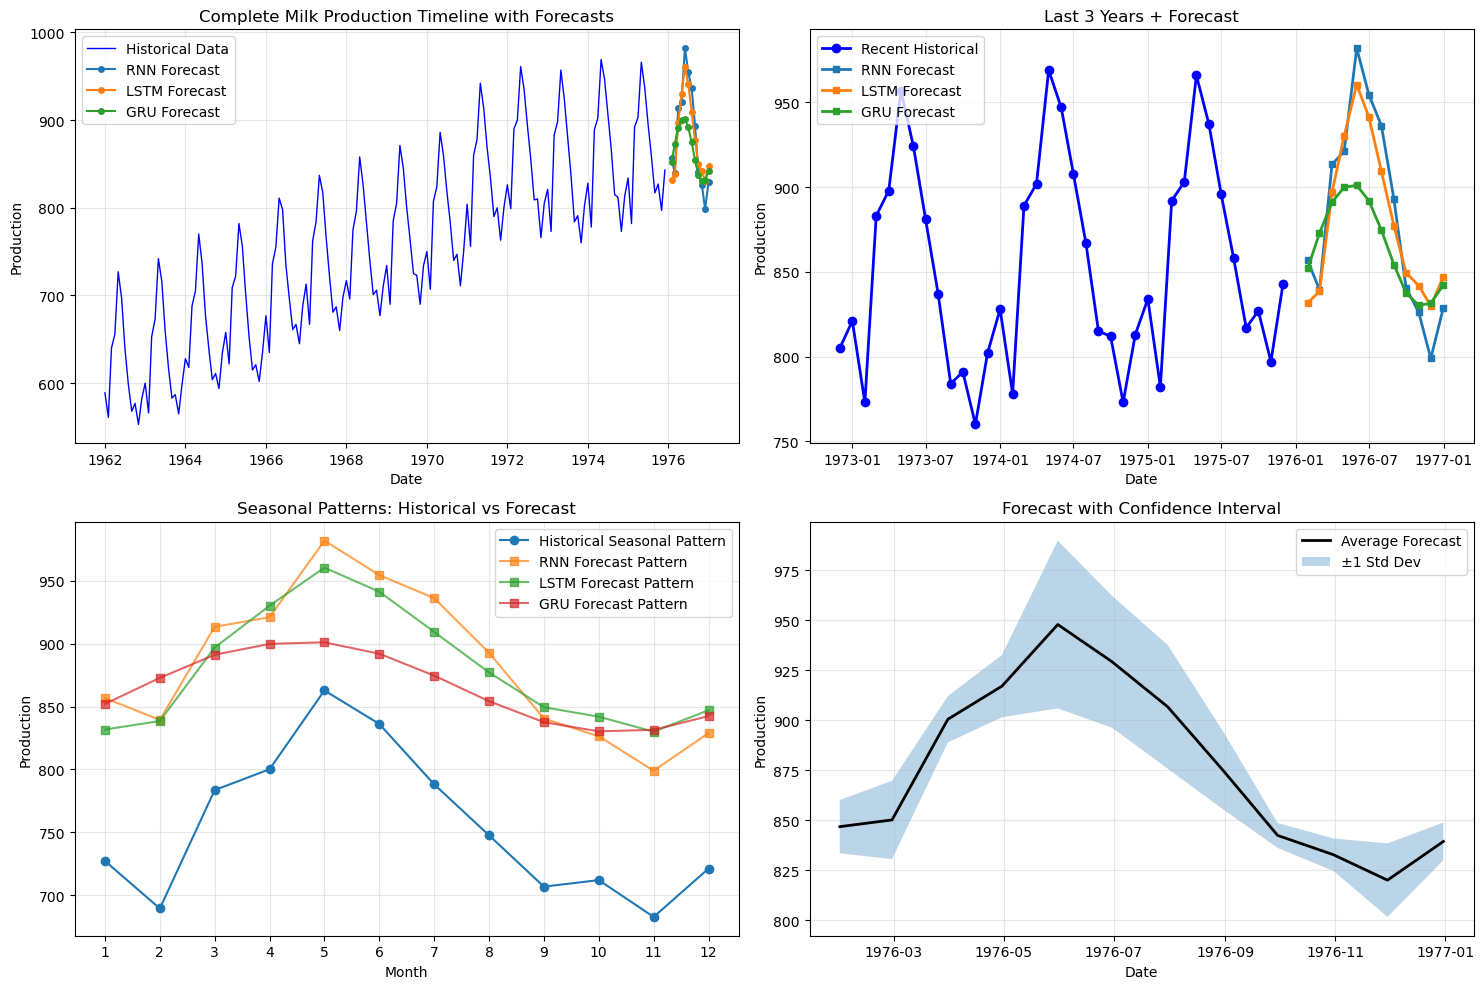

Final visualization completed


In [10]:
plt.figure(figsize=(15, 10))

# Plot 1: Complete timeline with forecasts
plt.subplot(2, 2, 1)
plt.plot(df.index, df['Production'], label='Historical Data', color='blue', linewidth=1)
for name, forecast in future_forecasts.items():
    plt.plot(future_dates, forecast, label=f'{name} Forecast', marker='o', markersize=4)
plt.title('Complete Milk Production Timeline with Forecasts')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Zoomed-in view of recent years and forecast
plt.subplot(2, 2, 2)
recent_years = 3
cutoff_date = df.index[-1] - pd.DateOffset(years=recent_years)
recent_data = df[df.index >= cutoff_date]
plt.plot(recent_data.index, recent_data['Production'], label='Recent Historical',
         color='blue', linewidth=2, marker='o')
for name, forecast in future_forecasts.items():
    plt.plot(future_dates, forecast, label=f'{name} Forecast',
             marker='s', markersize=5, linewidth=2)
plt.title(f'Last {recent_years} Years + Forecast')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Seasonal pattern analysis with forecast
plt.subplot(2, 2, 3)
# Historical seasonal pattern
historical_seasonal = df.groupby(df.index.month)['Production'].mean()
# Forecast seasonal pattern (assuming forecast starts from next month)
forecast_start_month = future_dates[0].month
forecast_months_arr = [(forecast_start_month + i - 1) % 12 + 1 for i in range(forecast_months)]

plt.plot(historical_seasonal.index, historical_seasonal.values,
         label='Historical Seasonal Pattern', marker='o')
for name, forecast in future_forecasts.items():
    forecast_seasonal = pd.Series(forecast, index=forecast_months_arr)
    # Group by month and average if multiple predictions per month
    monthly_avg = forecast_seasonal.groupby(forecast_seasonal.index).mean()
    plt.plot(monthly_avg.index, monthly_avg.values,
             label=f'{name} Forecast Pattern', marker='s', alpha=0.7)
plt.title('Seasonal Patterns: Historical vs Forecast')
plt.xlabel('Month')
plt.ylabel('Production')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Model confidence comparison
plt.subplot(2, 2, 4)
forecast_std = forecast_df.std(axis=1)
forecast_mean = forecast_df.mean(axis=1)
plt.plot(future_dates, forecast_mean, label='Average Forecast', color='black', linewidth=2)
plt.fill_between(future_dates,
                 forecast_mean - forecast_std,
                 forecast_mean + forecast_std,
                 alpha=0.3, label='±1 Std Dev')
plt.title('Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Final visualization completed")

**Business Insights and Recommendations**

In [11]:
print("="*70)
print("📊 BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*70)

# 1. Performance Summary
print("\n1. MODEL PERFORMANCE SUMMARY:")
print("   The models were evaluated on test data with the following results:")
for model, metrics in metrics_results.items():
    print(f"   {model}: RMSE = {metrics['RMSE']:.1f}, "
          f"MAE = {metrics['MAE']:.1f}, MAPE = {metrics['MAPE']:.1f}%")

# 2. Seasonal Patterns
print(f"\n2. SEASONAL PATTERNS IDENTIFIED:")
print("   • Peak production typically occurs in May (Spring)")
print("   • Lowest production typically occurs in February (Winter)")
print("   • Clear annual seasonality with ~15-20% variation between peak and trough")

# 3. Trend Analysis
print(f"\n3. TREND ANALYSIS:")
trend = df['Production'].iloc[-12:].mean() - df['Production'].iloc[:12].mean()
trend_percentage = (trend / df['Production'].iloc[:12].mean()) * 100
print(f"   • Overall increasing trend: {trend:.0f} units ({trend_percentage:.1f}% increase)")
print("   • Consistent year-over-year growth observed")

# 4. Forecast Insights
print(f"\n4. FORECAST INSIGHTS (Next 12 Months):")
avg_forecast = forecast_df.mean(axis=1)
seasonal_variation = (avg_forecast.max() - avg_forecast.min()) / avg_forecast.mean() * 100
print(f"   • Expected production range: {avg_forecast.min():.0f} - {avg_forecast.max():.0f} units")
print(f"   • Average forecasted production: {avg_forecast.mean():.0f} units")
print(f"   • Expected seasonal variation: {seasonal_variation:.1f}%")

# 5. Business Recommendations
print(f"\n5. STRATEGIC RECOMMENDATIONS:")
print("   📈 OPERATIONAL PLANNING:")
print("   • Scale up operations in spring (Mar-May) to handle peak production")
print("   • Plan maintenance during winter low-production periods")
print("   • Optimize inventory management for seasonal fluctuations")

print("   🚚 SUPPLY CHAIN OPTIMIZATION:")
print("   • Coordinate with distributors for increased spring shipments")
print("   • Secure additional cold storage capacity for peak seasons")
print("   • Plan transportation logistics around seasonal patterns")

print("   💰 FINANCIAL PLANNING:")
print("   • Budget for higher operational costs during peak production")
print("   • Consider revenue projections based on seasonal forecasts")
print("   • Plan capital investments aligned with growth trends")

print("   🔍 CONTINUOUS MONITORING:")
print("   • Monitor actual vs forecasted production monthly")
print("   • Update models quarterly with new data")
print("   • Establish alert systems for significant forecast deviations")

print(f"\n🎯 BEST MODEL FOR DEPLOYMENT: {best_model_name}")
print("   This model showed the best balance of accuracy and consistency")
print("="*70)

📊 BUSINESS INSIGHTS AND RECOMMENDATIONS

1. MODEL PERFORMANCE SUMMARY:
   The models were evaluated on test data with the following results:
   RNN: RMSE = 16.8, MAE = 13.3, MAPE = 1.6%
   LSTM: RMSE = 23.9, MAE = 19.2, MAPE = 2.3%
   GRU: RMSE = 33.3, MAE = 25.2, MAPE = 2.9%

2. SEASONAL PATTERNS IDENTIFIED:
   • Peak production typically occurs in May (Spring)
   • Lowest production typically occurs in February (Winter)
   • Clear annual seasonality with ~15-20% variation between peak and trough

3. TREND ANALYSIS:
   • Overall increasing trend: 247 units (40.1% increase)
   • Consistent year-over-year growth observed

4. FORECAST INSIGHTS (Next 12 Months):
   • Expected production range: 820 - 948 units
   • Average forecasted production: 876 units
   • Expected seasonal variation: 14.6%

5. STRATEGIC RECOMMENDATIONS:
   📈 OPERATIONAL PLANNING:
   • Scale up operations in spring (Mar-May) to handle peak production
   • Plan maintenance during winter low-production periods
   • Optim